# Day 22

## Part 1

- to pass the force field a path must be traced on a board
- the first part of the notes is a map of the board
- the 2nd half is the path description:
    - numbers indicate number of steps to go
    - letters indicate whether to turn left or right in place
- start at the leftmost tile in the top row facing to the right
- paths wrap around to the other side of the map if they go off the edge
- if a wall is on the other side of the map, this counts as being in the way
- determine the `row`, `column` and `facing` at the final position
    - rows start from 1 at the top
    - column 1 starts at the left
    - direction:
        - right = 0
        - down = 1
        - left = 2
        - up = 3
- the final password is: 1000 * `row` + 4 * `column` + `facing`

`What is the final password?`

In [1]:
from dataclasses import dataclass
from matplotlib import pyplot as plt
import numpy as np
from utils import parse_from_file, ParseConfig

parser = ParseConfig('\n\n', [
    ParseConfig('\n', ParseConfig('', str)),
    str
])

board, direction_input = parse_from_file(
        'day_22.txt', parser)

print(f'directions: {direction_input[:10]}...')
print(f'board: [{board[0]}, ...]')

directions: 35L7L12L18...
board: [[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '.', '.', '.', '.', '.', '.', '.', '.', '.', '#', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '#', '.', '.', '.', '.', '.', '.', '.', '.', '.', '#', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '#', '#', '#', '.', '#', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '#', '.', '#', '.', '.', '#', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.'], ...]


In [2]:
# let's pad the board with void on the sides that aren't quite as long
max_width = max([len(row) for row in board])
for row in board:
    while len(row) < max_width:
        row.append(' ')

Text(0.5, 1.0, 'board already?!')

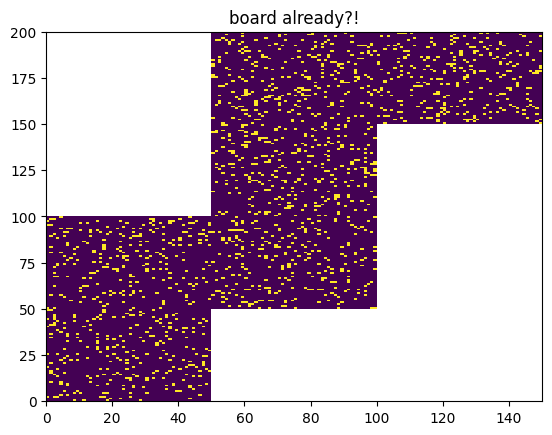

In [3]:
def plot_board_and_path(
    board: list[list[str]], path: list[tuple[int]]
) -> tuple[plt.Figure, list[list[plt.Axes]]]:
    """
    creates a pcolormesh plot of a board with a plot superimposed on top
    """
    void = np.nan
    floor = 0
    wall = len(path) + 1
    grid_width = max([len(row) for row in board])
    grid = []
    for row in board:
        grid.append([])
        for material in row:
            match material:
                case ' ':
                    value = void
                case '.':
                    value = floor
                case '#':
                    value = wall
            grid[-1].append(value)
        while len(grid[-1]) < grid_width:
            grid[-1].append(void)

    for step, (x, y) in enumerate(path, 1):
        grid[y][x] = step

    fig, ax = plt.subplots()
    ax.pcolormesh(list(reversed(grid)))

    return fig, ax

fig, ax = plot_board_and_path(board, [])
ax.set_title('board already?!')

In [4]:
# find the start point
for x, material in enumerate(board[0]):
    match material:
        case '.':
            start = (x, 0)
            break
        case _:
            continue

print(start)

(50, 0)


In [5]:
# now let's parse the path input
directions = []
buffer = ''
for char in direction_input:
    if char in ('L', 'R'):
        directions.append(int(buffer))
        directions.append(char)
        buffer = ''
        continue
    buffer += char
directions.append(int(buffer))

print(directions[:10], directions[-10:])

[35, 'L', 7, 'L', 12, 'L', 18, 'R', 42, 'R'] ['L', 20, 'R', 32, 'L', 23, 'L', 32, 'L', 39]


In [6]:
# let's goooo!
right, down, left, up = (1, 0), (0, 1), (-1, 0), (0, -1)
turn_right = {right: down, down: left, left: up, up: right}
turn_left = {right: up, up: left, left: down, down: right}
facing = right
positions = [start]
for index, step in enumerate(directions):
    print(f'step #: {index}' + ' '*10, end='\r')
    # if we need to turn
    if step == 'R':
        facing = turn_right[facing]
        continue
    elif step == 'L':
        facing = turn_left[facing]
        continue
    # else let's move forward
    for _ in range(step):
        x, y = [value + delta for value, delta in zip(positions[-1], facing)]
        # run position off and around if off the board until we get back
        x %= len(board[0])
        y %= len(board)
        while board[y][x] == ' ':
            x, y = [
                value + delta for value, delta in zip((x, y), facing)]
            x %= len(board[0])
            y %= len(board)
        # now check if we hit a wall
        if board[y][x] == '#':
            continue
        # if not, continue moving that way
        positions.append((x, y))

Text(0.5, 1.0, 'a little bit round the houses')

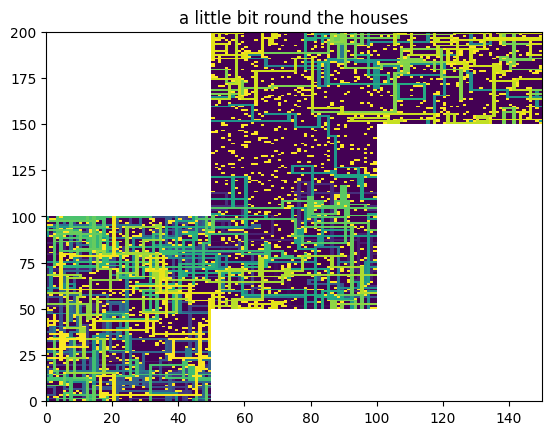

In [7]:
fig, ax = plot_board_and_path(board, positions)
ax.set_title('a little bit round the houses')

In [8]:
col, row = [value + 1 for value in positions[-1]]
facing_scores = {right: 0, down: 1, left: 2, up: 3}
facing_score = facing_scores[facing]

final_password = 1000 * row + 4 * col + facing_score

print(f'the final password is {final_password}!')

the final password is 164014!


## Part 2

- it's a cube! There are 6 50x50 sections that make up a net.
- instead of wrapping around the net, going off a face means heading onto the next face of the cube

`Fold the map into a cube, then follow the path given in the monkeys' notes. What is the final password?`

In [18]:
# let's do all the smarts beforehand and figure out a mapping of coordinates
@dataclass
class Neighbour:
    coords: tuple[int]
    facing: tuple[int]

# at this point I drew the net on paper, labelled the edges and cut them out
# with a scalple

# here are the edge points for each edge
A = [(x, -1) for x in range(50, 100)]
B = [(x, -1) for x in range(100, 150)]
C = [(150, y) for y in range(0, 50)]
D = [(x, 50) for x in range(100, 150)]
E = [(100, y) for y in range(50, 100)]
F = [(100, y) for y in range(100, 150)]
G = [(x, 150) for x in range(50, 100)]
H = [(50, y) for y in range(150, 200)]
I = [(x, 200) for x in range(0, 50)]
J = [(-1, y) for y in range(150, 200)]
K = [(-1, y) for y in range(100, 150)]
L = [(x, 99) for x in range(0, 50)]
M = [(49, y) for y in range(50, 100)]
N = [(49, y) for y in range(0, 50)]

# the direction of entry is required because there are 3 points along the edge
# of the net that are shared by 2 edges
edge_mapping = [
    (A, up, J, 'same', right),
    (B, up, I, 'same', up),
    (C, right, F, 'reverse', left),
    (D, down, E, 'same', left),
    (E, right, D, 'same', up),
    (F, right, C, 'reverse', left),
    (G, down, H, 'same', left),
    (H, right, G, 'same', up),
    (I, down, B, 'same', down),
    (J, left, A, 'same', down),
    (K, left, N, 'reverse', right),
    (L, up, M, 'same', right),
    (M, left, L, 'same', down),
    (N, left, K, 'reverse', right)
]

neighbours = {}
for points, exit_dir, neighbour_points, map_order, facing in edge_mapping:
    if map_order == 'reverse':
        correct_neighbours = reversed(neighbour_points)
    else:
        correct_neighbours = neighbour_points
    for point, neighbour in zip(points, correct_neighbours):
        neighbours.update({(point, exit_dir): Neighbour(neighbour, facing)})

print(list(neighbours.items())[:3])

[(((50, -1), (0, -1)), Neighbour(coords=(-1, 150), facing=(1, 0))), (((51, -1), (0, -1)), Neighbour(coords=(-1, 151), facing=(1, 0))), (((52, -1), (0, -1)), Neighbour(coords=(-1, 152), facing=(1, 0)))]


In [25]:
# let's do it!
right, down, left, up = (1, 0), (0, 1), (-1, 0), (0, -1)
turn_right = {right: down, down: left, left: up, up: right}
turn_left = {right: up, up: left, left: down, down: right}
facing = right
positions = [start]
for index, step in enumerate(directions):
    print(f'step #: {index}' + ' '*10, end='\r')
    # if we need to turn
    if step == 'R':
        facing = turn_right[facing]
        continue
    elif step == 'L':
        facing = turn_left[facing]
        continue
    # else let's move forward
    for _ in range(step):
        x, y = [value + delta for value, delta in zip(positions[-1], facing)]
        # if we've gone off the edge of the net
        if ((x, y), facing) in neighbours:
            neighbour = neighbours[((x, y), facing)]
            x, y = [
                value + delta for value, delta
                in zip(neighbour.coords, neighbour.facing)
            ]
            if board[y][x] == '#':
                continue
            # if there isn't a wall update the facing direction as well
            facing = neighbour.facing

        # if not off an edge, just check for a wall
        elif board[y][x] == '#':
            continue
        # if no walls move to x, y and keep going
        positions.append((x, y))

Text(0.5, 1.0, "don't worry, it's just around the block")

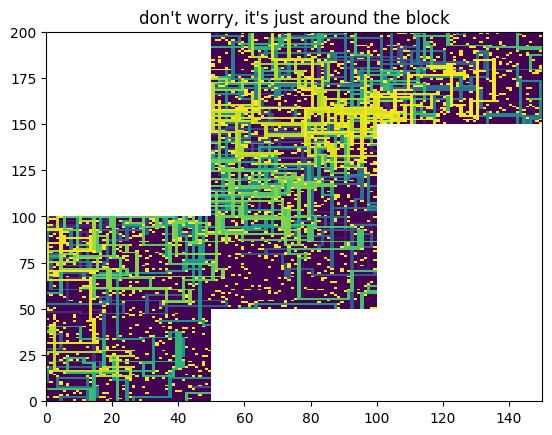

In [26]:
fig, ax = plot_board_and_path(board, positions)
ax.set_title('don\'t worry, it\'s just around the block')

In [27]:
col, row = [value + 1 for value in positions[-1]]
facing_scores = {right: 0, down: 1, left: 2, up: 3}
facing_score = facing_scores[facing]

final_cube_password = 1000 * row + 4 * col + facing_score

print(f'the final password is {final_cube_password}!')

the final password is 47525!
